<a href="https://colab.research.google.com/github/Lubraca/Unsupervised_ML_Models/blob/main/KMeans_wine_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

wine = datasets.load_wine()
X = wine.data
Y = wine.target

n_samples, n_features = X.shape

In [2]:
print(n_samples, n_features)

178 13


In [15]:
X_df = pd.DataFrame(X, columns=wine.feature_names)
X_df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


In [17]:
Y_df = pd.DataFrame(Y, columns=['Wine Type'])
Y_df['Wine Type'].value_counts()


,count
Wine Type,
1,71
0,59
2,48


In [18]:
# Because Wine features live on very different scales (e.g., Proline vs Hue), scaling is mandatory—otherwise K-Means mostly clusters by whichever feature has the biggest numeric range.

In [20]:
X_scaled = X_df.copy()
X_scaled = StandardScaler().fit_transform(X_scaled)


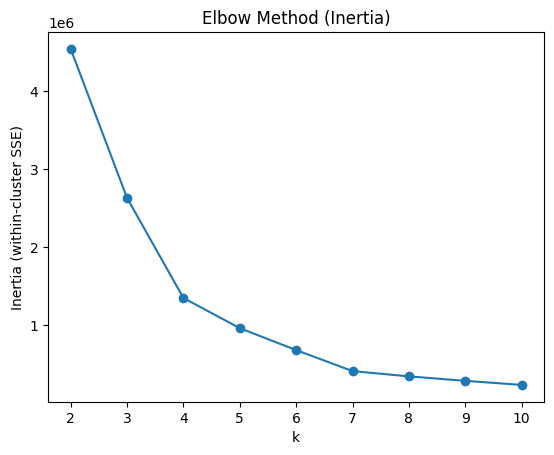

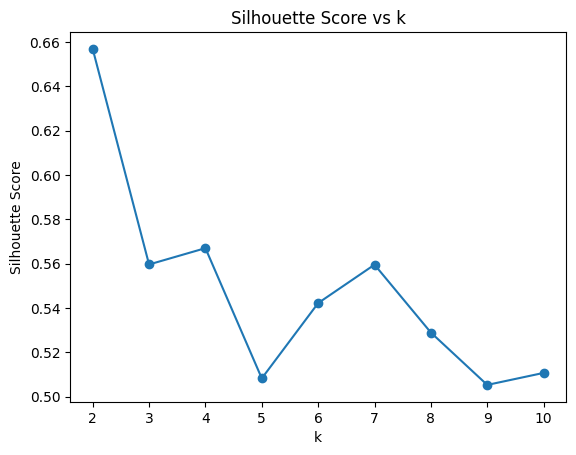

In [26]:
# KMeans with silhouette Score and inertia

scores = []
inertia = []
k_range  = range(2, 11)

for k in k_range:
    model = KMeans(n_clusters = k, random_state=42)
    labels = model.fit_predict(X)
    model.fit(X)
    inertia.append(model.inertia_)
    score = silhouette_score(X, labels)
    scores.append(score)

# Plot inertia (Elbow)
plt.figure()
plt.plot(list(k_range), inertia, marker="o")
plt.xlabel("k")
plt.ylabel("Inertia (within-cluster SSE)")
plt.title("Elbow Method (Inertia)")
plt.show()

# Plot silhouette
plt.figure()
plt.plot(list(k_range), scores, marker="o")
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs k")
plt.show()


In [30]:
best_k = list(k_range)[int(np.argmax(scores))]
print("Best k by silhouette:", best_k)

Best k by silhouette: 2


In [36]:
# Create pipeline with best nummber of clusters
final_k = best_k

pipe =  Pipeline([
    ('scaler', StandardScaler()),
    ('kmeans', KMeans(n_clusters=final_k, n_init = "auto", random_state = 42))
])

pipe.fit(X)

labels = pipe.predict(X)

print("Final k:", final_k)
print("Final inertia:", pipe.named_steps["kmeans"].inertia_)
print("Final silhouette:", silhouette_score(StandardScaler().fit_transform(X), labels))


Final k: 2
Final inertia: 1661.6761165626497
Final silhouette: 0.2650328591008738


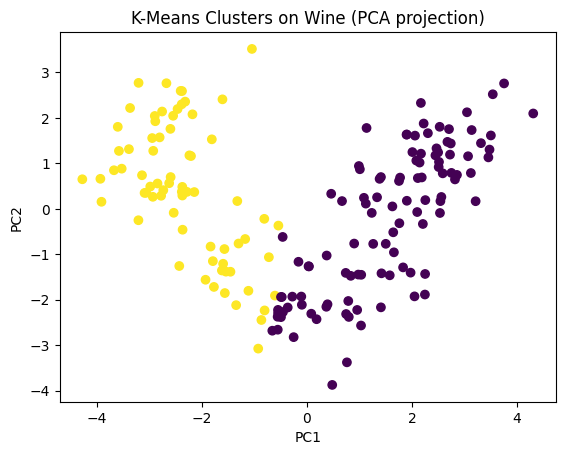

Explained variance ratio (PC1, PC2): [0.36198848 0.1920749 ]


In [37]:
# Visualize clusters in 2D using PCA

X_scaled = StandardScaler().fit_transform(X)
pca = PCA(n_components=2, random_state=42)
X_2d = pca.fit_transform(X_scaled)

plt.figure()
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("K-Means Clusters on Wine (PCA projection)")
plt.show()

print("Explained variance ratio (PC1, PC2):", pca.explained_variance_ratio_)

In [41]:
# Interpret clusters (centroids in original feature space)
kmeans = pipe.named_steps["kmeans"]
scaler = pipe.named_steps["scaler"]

centroids_scaled = kmeans.cluster_centers_
centroids_original = scaler.inverse_transform(centroids_scaled)

centroids_df = pd.DataFrame(centroids_original, columns=X_df.columns)
centroids_df["cluster"] = range(final_k)

# Show top distinguishing features by centroid spread
spread = centroids_df[X_df.columns].max() - centroids_df[X_df.columns].min()
top_features = spread.sort_values(ascending=False).head(6).index.tolist()

print("Top distinguishing features:", top_features)
display(centroids_df[["cluster"] + top_features].round(3))


Top distinguishing features: ['proline', 'magnesium', 'alcalinity_of_ash', 'flavanoids', 'color_intensity', 'od280/od315_of_diluted_wines']


,cluster,proline,magnesium,alcalinity_of_ash,flavanoids,color_intensity,od280/od315_of_diluted_wines
0,0,848.168,101.065,18.479,2.698,4.416,3.092
1,1,594.268,97.746,21.027,1.022,6.026,1.888


In [43]:
# Sanity Check

ct = pd.crosstab(pd.Series(Y, name="true_class"),
                 pd.Series(labels, name="cluster"))
print(ct)



cluster      0   1
true_class        
0           59   0
1           48  23
2            0  48
